In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import gc
import torch
import time

from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_experimental.text_splitter import SemanticChunker
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [2]:
embeddings = HuggingFaceEmbeddings(model='BAAI/bge-m3', model_kwargs={'device':'cuda'}, encode_kwargs={'batch_size':8})
model = ChatOpenAI(model='gpt-5-mini', temperature=0)

In [3]:
text = """
[글로벌 AI 반도체 패권 전쟁: 2024년 시장 분석 보고서]

1. 서론: AI 시대의 도래와 반도체의 중요성
2024년, 인공지능(AI) 기술의 폭발적인 발전은 전 세계 산업 지형을 송두리째 바꾸고 있다. 특히 생성형 AI 모델인 GPT-4와 같은 거대언어모델(LLM)의 등장으로 인해, 이를 구동하기 위한 AI 가속기와 고성능 메모리 반도체의 수요가 급증하고 있다. 현재 AI 반도체 시장은 '설계'와 '생산', 그리고 '메모리'라는 세 가지 축을 중심으로 치열한 전쟁이 벌어지고 있다.

2. GPU 시장의 절대 강자: 엔비디아(NVIDIA)
젠슨 황 CEO가 이끄는 엔비디아는 AI 가속기(GPU) 시장에서 90% 이상의 점유율을 차지하며 사실상의 독점 체제를 구축했다. 엔비디아의 주력 제품인 H100과 차세대 칩 블랙웰(Blackwell)은 없어서 못 팔 정도의 인기를 누리고 있다. 구글, 마이크로소프트(MS), 메타(Meta), 아마존 등 미국의 빅테크 기업들은 엔비디아의 GPU를 확보하기 위해 천문학적인 자금을 쏟아붓고 있다. 하지만 이들 빅테크 기업들은 엔비디아에 대한 의존도를 낮추기 위해 자체 AI 칩 개발에도 착수했다.

3. 메모리 반도체 전쟁: HBM의 부상
AI 연산을 위해서는 GPU뿐만 아니라 데이터를 빠르게 공급해줄 고대역폭메모리(HBM)가 필수적이다. 이 분야에서는 대한민국의 SK하이닉스가 시장을 주도하고 있다. 곽노정 CEO가 이끄는 SK하이닉스는 엔비디아에 4세대 HBM인 HBM3를 사실상 독점 공급하며 주가를 크게 올렸다. SK하이닉스는 최근 5세대 제품인 HBM3E의 양산에도 성공하며 기술 리더십을 공고히 하고 있다.

반면, 이재용 회장이 이끄는 삼성전자는 HBM 시장 진입이 다소 늦었다는 평가를 받았다. 삼성전자는 이를 만회하기 위해 12단 HBM3E 제품 개발에 사활을 걸고 있으며, 엔비디아의 퀄리티 테스트(품질 인증) 통과를 위해 전사적인 역량을 집중하고 있다. 경계현 사장이 이끌던 DS부문은 최근 전영현 부회장 체제로 교체되며 쇄신을 꾀하고 있다. 삼성전자는 또한 '마하-1'이라는 자체 AI 추론용 칩을 개발하며 네이버와 협력하고 있다. 미국 마이크론 역시 HBM3E 개발에 성공하며 한국 기업들을 맹추격하고 있다.

4. 파운드리(위탁생산)의 제왕: TSMC
설계된 칩을 실제로 만들어내는 파운드리 분야에서는 대만의 TSMC가 압도적인 세계 1위다. 모리스 창이 창업한 TSMC는 애플, 엔비디아, AMD 등 글로벌 팹리스(설계 전문) 기업들의 최첨단 칩을 도맡아 생산하고 있다. 특히 AI 칩 생산에 필수적인 첨단 패키징 기술인 'CoWoS' 공정 능력에서 경쟁사들을 압도한다. 

삼성전자는 파운드리 분야에서 TSMC를 추격하기 위해 세계 최초로 GAA(Gate-All-Around) 기술을 적용한 3나노 공정을 선보였다. 삼성은 미국 텍사스주 테일러시에 거대한 파운드리 공장을 짓고 있으며, 이를 통해 미국 내 빅테크 고객사 확보를 노리고 있다. 한편, 미국의 인텔은 팻 겔싱어 CEO의 지휘 아래 'IDM 2.0' 전략을 내세우며 파운드리 사업 재진출을 선언했지만, 2024년 현재 막대한 적자로 인해 고전하고 있다.

5. 지정학적 리스크와 국가 간 경쟁
반도체는 이제 단순한 산업을 넘어 국가 안보의 핵심 자산이 되었다. 미국 정부는 '칩스법(CHIPS Act)'을 통해 자국 내 반도체 생산 시설 유치에 막대한 보조금을 지급하고 있다. 이에 따라 삼성전자, TSMC, 인텔 모두 미국 애리조나, 오하이오, 텍사스 등에 공장을 건설 중이다. 
대한민국 정부 역시 경기도 용인에 세계 최대 규모의 '반도체 클러스터'를 조성하겠다는 계획을 발표했다. 윤석열 대통령은 반도체 산업에 대한 전폭적인 지원을 약속하며 네덜란드의 ASML과 협력을 강화했다. ASML은 최첨단 칩 생산에 필수적인 EUV(극자외선) 노광 장비를 독점 생산하는 기업이다.

결론적으로, 2024년의 반도체 시장은 엔비디아의 독주 속에 삼성전자와 SK하이닉스의 HBM 전쟁, 그리고 TSMC를 넘어서려는 파운드리 경쟁이 복합적으로 얽혀 있다. 최후의 승자가 누가 될지는 아직 미지수다.
"""

documents = [Document(page_content=text)]

In [4]:
system_ai = """You are a data expert who extracts organization and knowledge graphs from text.
        
        Rules:
        1. Extract nodes and edges based on the input text.
        2. **Do NOT translate entities.** Keep the original language (Korean) for the names of nodes. (e.g., '삼성전자' must be '삼성전자', not 'Samsung Electronics').
        3. Use the given allowed nodes and relationships if provided.
        """

prompt_template = ChatPromptTemplate.from_messages(
    [('system', system_ai), ('human', 'Input text: {input}')]
)

In [5]:
llm_transformer = LLMGraphTransformer(
    llm=model,
    prompt=prompt_template
)
print(llm_transformer)

In [6]:
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(graph_documents)
print(f'노드: {len(graph_documents[0].nodes)}')
print(f'엣지: {len(graph_documents[0].relationships)}')

[GraphDocument(nodes=[Node(id='엔비디아', type='Company', properties={}), Node(id='Sk하이닉스', type='Company', properties={}), Node(id='삼성전자', type='Company', properties={}), Node(id='구글', type='Company', properties={}), Node(id='마이크로소프트', type='Company', properties={}), Node(id='메타', type='Company', properties={}), Node(id='아마존', type='Company', properties={}), Node(id='네이버', type='Company', properties={}), Node(id='마이크론', type='Company', properties={}), Node(id='Tsmc', type='Company', properties={}), Node(id='Amd', type='Company', properties={}), Node(id='애플', type='Company', properties={}), Node(id='인텔', type='Company', properties={}), Node(id='Asml', type='Company', properties={}), Node(id='젠슨 황', type='Person', properties={}), Node(id='곽노정', type='Person', properties={}), Node(id='이재용', type='Person', properties={}), Node(id='경계현', type='Person', properties={}), Node(id='전영현', type='Person', properties={}), Node(id='팻 겔싱어', type='Person', properties={}), Node(id='모리스 창', type='Person', p

In [8]:
G = nx.DiGraph()

for doc in graph_documents:
    for node in doc.nodes:
        G.add_node(node.id, type=node.type)
    for edge in doc.relationships:
        G.add_edge(edge.source.id, edge.target.id, label=edge.type)

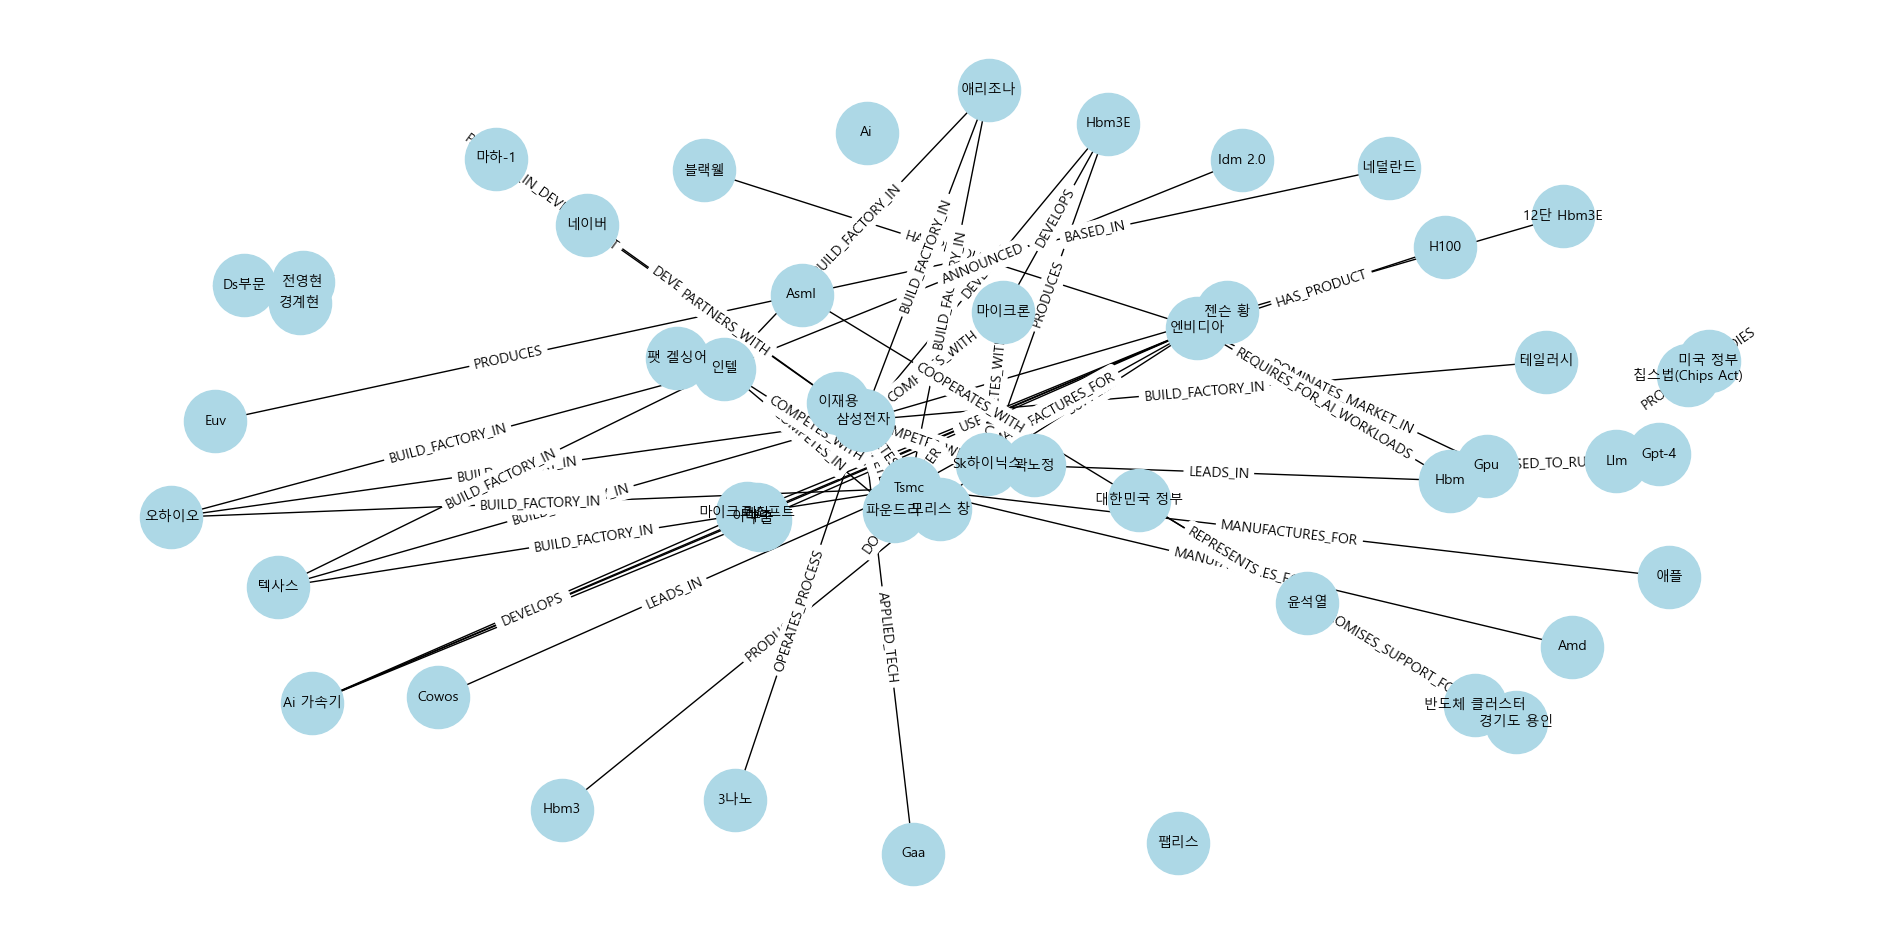

In [9]:
plt.figure(figsize=(24, 12))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='lightblue')
nx.draw_networkx_labels(G, pos, font_family='Malgun Gothic', font_size=10)

nx.draw_networkx_edges(G, pos, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_family='Malgun Gothic')

plt.axis('off')
plt.show()